In [9]:
import os
import matplotlib

matplotlib.use("Agg")
%matplotlib inline

import numpy as np
from functools import partial
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

import matplotlib.figure
import  matplotlib.axes
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from zoneinfo import ZoneInfo
import scienceplots # noqa: F401
plt.style.use(['science', 'no-latex'])

def save_fig4paper_plt(
    fig: matplotlib.figure.Figure,
    dirpath: Path,
    filename: str | None = None,
    dpi: int = 400,
    bbox_inches="tight",
    transparent: bool = False,
    is_remove_upright_tickline: bool = True,
    is_force_remove_grid: bool = True,
    fig_scales = [0.5, 0.75, 1.5, 2.0, 1], # 最後を1にして1の画像をnotebookに残すためのもの
):
    base_figsize = fig.get_size_inches()
    if not dirpath.exists():
        dirpath.mkdir(parents=True, exist_ok=True)
    if filename is None:
        filepath = (
            dirpath
            / f"{datetime.now(ZoneInfo('Asia/Tokyo')).strftime('%Y%m%d_%H%M%S')}"
        )
    else:
        filepath = dirpath / filename
    ax: matplotlib.axes._axes.Axes
    for ax in fig.axes:
        if is_remove_upright_tickline:
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.tick_params(axis="x", which="both", top=False)
            ax.tick_params(axis="y", which="both", right=False)
        if is_force_remove_grid:
            ax.grid(False)
    for scale in fig_scales:
        figsize = base_figsize*scale
        fig.set_size_inches(figsize)
        # fig.tight_layout()
        fig.savefig(
            str(filepath) + f"_fs[{figsize[0].item()}, {figsize[1].item()}].png",
            dpi=dpi,
            bbox_inches=bbox_inches,
            transparent=transparent,
            pad_inches=0.05,
        )
    return fig


# plt.rcParams['font.family'] ='sans-serif'
# plt.rcParams['font.family'] ='Times New Roman'
# plt.rcParams["font.family"] = "DeJavu Serif"
# plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
# plt.rcParams["xtick.direction"] = "in"
# plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (6.0, 4.0)
# plt.rcParams["axes.linewidth"] = 1.0
# plt.rcParams["errorbar.capsize"] = 6
# plt.rcParams["lines.markersize"] = 7

In [ ]:
class PulseStimulusGenerator:
    def __init__(
        self,
        T,
        dt,
        pulse_duration,
        inter_pulse_interval,
        pulse_amp=1.,
        start_offset=None,
    ) -> None:
        self.T = T
        self.dt = dt
        self.pulse_duration = pulse_duration
        self.inter_pulse_interval = inter_pulse_interval
        self.pulse_amp = pulse_amp

        self.n_timestep = int(T / dt)

        self.list_pulse_start_time = []
        self.list_pulse_end_time = []
        temp_time = inter_pulse_interval / 2.0 if start_offset is None else start_offset
        self.list_pulse_start_time.append(temp_time)
        while temp_time < T:
            temp_time = temp_time + pulse_duration
            self.list_pulse_end_time.append(temp_time)
            temp_time = temp_time + inter_pulse_interval
            self.list_pulse_start_time.append(temp_time)

        self.get_from_timevector = np.vectorize(self.get_from_time)

    def get_from_time(self, t):
        list_is_in_pulse = np.asarray(
            [
                self.list_pulse_start_time[i] < t and self.list_pulse_end_time[i] > t
                for i in range(len(self.list_pulse_start_time))
            ]
        )
        if list_is_in_pulse.any():
            return self.pulse_amp
        else:
            return 0.


def f_2var(state, t, f_eI, gamma, beta, tc_x=1):
    x = state[0]
    a = state[1]

    dx = tc_x * (-x + a + f_eI(t))
    da = -gamma * a + beta * x
    return np.hstack([dx, da])


def rk_step(i, ys, dt, f):
    t = dt * i
    k1 = f(ys, t)
    k2 = f(ys + dt * k1 / 2.0, t + dt / 2.0)
    k3 = f(ys + dt * k2 / 2.0, t + dt / 2.0)
    k4 = f(ys + dt * k3, t + dt)

    dydt = 1.0 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    ysi = ys + dydt * dt
    return ysi


def plot_figure(
    T,
    dt,
    gamma,
    beta,
    gamma2=None,
    beta2=None,
    betas=None,
    is_plot_x=True,
    is_plot_a=False,
    tc_x=1,
    is_flip_pulse_sign=True,
    pulse_amp=1.,
    pulse_duration=0.05,
    inter_pulse_interval=10.,
    fname="model_response_to_pulse_stimulus.png",
):
    color_gpa = (0, 0, 0)  # (234/255., 177/255., 54/255.) #
    color_common = (0, 0, 0)  # (41/255., 121/255., 236/255.) #
    color_eI = (0, 0, 0)  #
    alpha = 1.0

    timearray = np.arange(0, T, dt)
    psg = PulseStimulusGenerator(
        T=T, dt=dt, pulse_duration=pulse_duration, inter_pulse_interval=inter_pulse_interval, pulse_amp=pulse_amp
    )
    neg_psg = PulseStimulusGenerator(
        T=T, dt=dt, pulse_duration=pulse_duration, inter_pulse_interval=inter_pulse_interval, pulse_amp=-pulse_amp
    )
    
    def switch_psg(t):
        if t < T * 3 / 5.0:
            return psg.get_from_time(t)
        else:
            return neg_psg.get_from_time(t)

    if is_flip_pulse_sign:
        f_eI = switch_psg
    else:
        f_eI = psg.get_from_time

    t_f_2var = partial(f_2var, gamma=gamma, beta=beta, f_eI=f_eI, tc_x=tc_x)
    ys = np.zeros([timearray.size, 2])
    ys[0, :] = np.zeros(2)  # np.random.normal(size=2)
    for i in range(1, timearray.size):
        ys[i, :] = rk_step(i - 1, ys[i - 1], dt, t_f_2var)

    if (is_plot_a or is_plot_x) and not (is_plot_a and is_plot_x):
        fig = plt.figure(constrained_layout=True)
        gs = gridspec.GridSpec(6, 1, figure=fig)
        ax = fig.add_subplot(gs[:-1])
        if is_plot_x:
            ax.plot(
                timearray,
                ys[:, 0],
                label="x",
                linewidth=2,
                alpha=alpha,
                color=color_gpa,
            )
        if is_plot_a:
            ax.plot(
                timearray, ys[:, 1], label="a", color="blue", linewidth=2, alpha=alpha
            )

        if gamma2 is not None:
            t_f_2var = partial(
                f_2var, gamma=gamma2, beta=beta, f_eI=f_eI, tc_x=tc_x
            )
            ys = np.zeros([timearray.size, 2])
            ys[0, :] = np.zeros(2)  # np.random.normal(size=2)
            for i in range(1, timearray.size):
                ys[i, :] = rk_step(i - 1, ys[i - 1], dt, t_f_2var)
            if is_plot_x:
                ax.plot(
                    timearray,
                    ys[:, 0],
                    label="x",
                    linewidth=2,
                    alpha=alpha,
                    linestyle="--",
                    color=color_common,
                )
            if is_plot_a:
                ax.plot(
                    timearray,
                    ys[:, 1],
                    label="a",
                    color="blue",
                    linewidth=2,
                    alpha=alpha,
                    linestyle="--",
                )
        if beta2 is not None:
            t_f_2var = partial(
                f_2var, gamma=gamma, beta=beta2, f_eI=f_eI, tc_x=tc_x
            )
            ys = np.zeros([timearray.size, 2])
            ys[0, :] = np.zeros(2)  # np.random.normal(size=2)
            for i in range(1, timearray.size):
                ys[i, :] = rk_step(i - 1, ys[i - 1], dt, t_f_2var)
            if is_plot_x:
                ax.plot(
                    timearray,
                    ys[:, 0],
                    label="x",
                    color="black",
                    linewidth=2,
                    alpha=alpha,
                    linestyle=":",
                )
            if is_plot_a:
                ax.plot(
                    timearray,
                    ys[:, 1],
                    label="a",
                    color="blue",
                    linewidth=2,
                    alpha=alpha,
                    linestyle=":",
                )

        # ax.plot(timearray, ys[:,1], label="a")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.yaxis.set_major_locator(MaxNLocator(3))
        ax.xaxis.set_major_locator(MaxNLocator(3))
        ax.tick_params(direction="in")

        ylabel = ""
        if is_plot_x:
            ylabel += r"$x(t)$"
        if is_plot_a:
            if len(ylabel) != 0:
                ylabel += ", "
            ylabel += r"$a(t)$"
        ax.set_ylabel(ylabel)
        # ax.legend()
        n_col = 1
    else:
        n_col = 2 if (gamma2 is not None) or (beta2 is not None) else 1

        fig = plt.figure(figsize=[5 * n_col, 7], constrained_layout=True)
        gs = gridspec.GridSpec(11, n_col, figure=fig)

        for i in range(n_col):
            if i == 1:
                if gamma2 is not None:
                    t_f_2var = partial(
                        f_2var, gamma=gamma2, beta=beta, f_eI=switch_psg, tc_x=tc_x
                    )
                if beta2 is not None or betas is not None:
                    t_f_2var = partial(
                        f_2var, gamma=gamma, beta=beta2, f_eI=switch_psg, tc_x=tc_x
                    )
                ys = np.zeros([timearray.size, 2])
                ys[0, :] = np.zeros(2)  # np.random.normal(size=2)
                for j in range(1, timearray.size):
                    ys[j, :] = rk_step(j - 1, ys[j - 1], dt, t_f_2var)
            if i == 0:
                ax1 = fig.add_subplot(gs[:5, i])
            else:
                ax1 = fig.add_subplot(gs[:5, i], sharey=prev_ax)
            ax1.plot(
                timearray,
                ys[:, 0],
                label="x",
                linewidth=2,
                alpha=alpha,
                color=color_gpa,
            )
            ax1.spines["right"].set_visible(False)
            ax1.spines["top"].set_visible(False)
            ax1.yaxis.set_major_locator(MaxNLocator(3))
            ax1.xaxis.set_major_locator(MaxNLocator(3))
            ax1.tick_params(direction="in")
            if i == 0:
                ax1.set_ylabel(r"$x(t)$")
            prev_ax = ax1

            ax2 = fig.add_subplot(gs[5:10, i], sharey=ax1)
            ax2.plot(
                timearray, ys[:, 1], label="a", color="black", linewidth=2, alpha=alpha
            )
            ax2.spines["right"].set_visible(False)
            ax2.spines["top"].set_visible(False)
            ax2.yaxis.set_major_locator(MaxNLocator(3))
            ax2.xaxis.set_major_locator(MaxNLocator(3))
            ax2.tick_params(direction="in")
            if i == 0:
                ax2.set_ylabel(r"$a(t)$")

    for i in range(n_col):
        ax = fig.add_subplot(gs[-1, i])
        ax.plot(
            timearray,
            np.vectorize(f_eI)(timearray),
            linewidth=2,
            alpha=alpha,
            color=color_eI,
        )
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.tick_params(direction="in")
        ax.set_xlabel("time (s)")
        if i == 0:
            ax.set_ylabel("external input")
        else:
            pass

    # fig.savefig(os.getcwd() + "/" + fname)
    # fig.savefig(os.getcwd() + "/" + fname + "dpi200.png", dpi=200)
    return fig

# Fig1

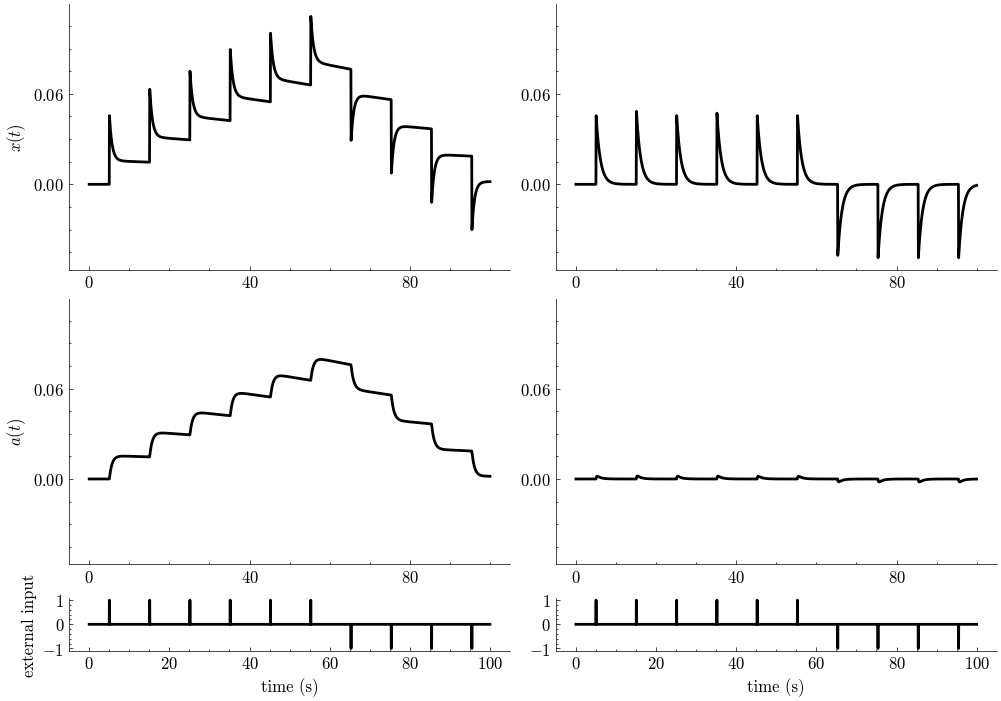

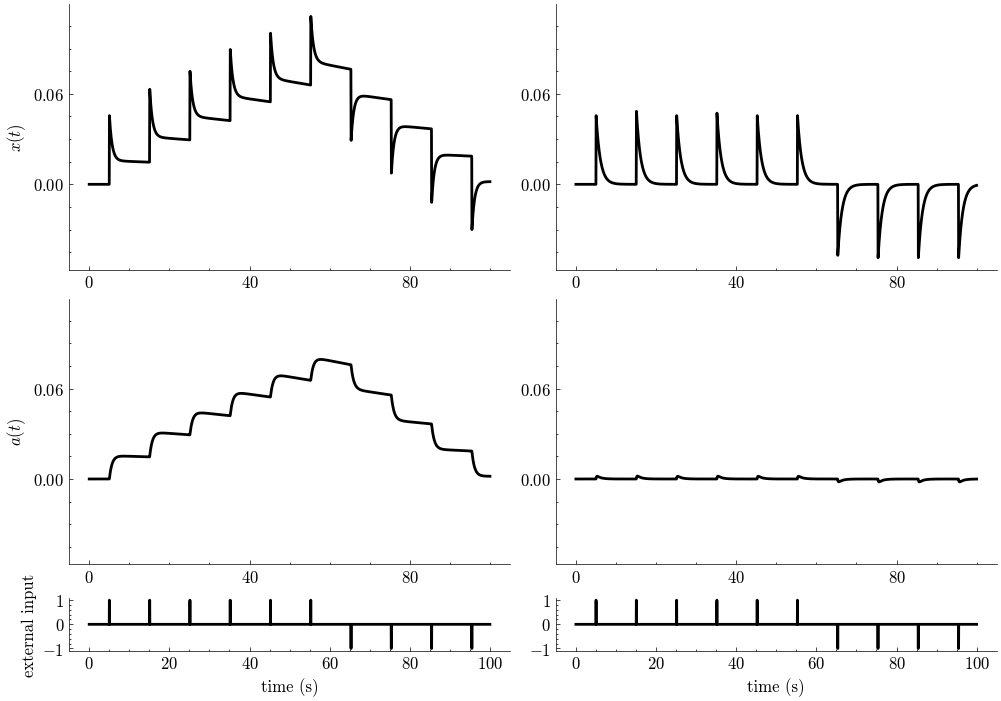

In [10]:
fig = plot_figure(
    T=100,
    dt=0.01,
    gamma=0.51,
    beta=0.5,
    gamma2=10,
    is_plot_x=True,
    is_plot_a=True,
    fname="model_response_to_pulse_stimulus_heterogamma_v3.png",
)
save_fig4paper_plt(
    fig=fig,
    dirpath=Path("figs"),
    filename="fig1.png",

)